In [1]:
import pandas as pd
import numpy as np
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

<class 'pandas.core.frame.DataFrame'>
Index: 1100702 entries, 0 to 1296674
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1100702 non-null  int64  
 1   trans_date_trans_time  1100702 non-null  object 
 2   cc_num                 1100702 non-null  int64  
 3   merchant               1100702 non-null  object 
 4   category               1100702 non-null  object 
 5   amt                    1100702 non-null  float64
 6   gender                 1100702 non-null  object 
 7   city                   1100702 non-null  object 
 8   state                  1100702 non-null  object 
 9   zip                    1100702 non-null  int64  
 10  lat                    1100702 non-null  float64
 11  long                   1100702 non-null  float64
 12  city_pop               1100702 non-null  int64  
 13  job                    1100702 non-null  object 
 14  dob                    

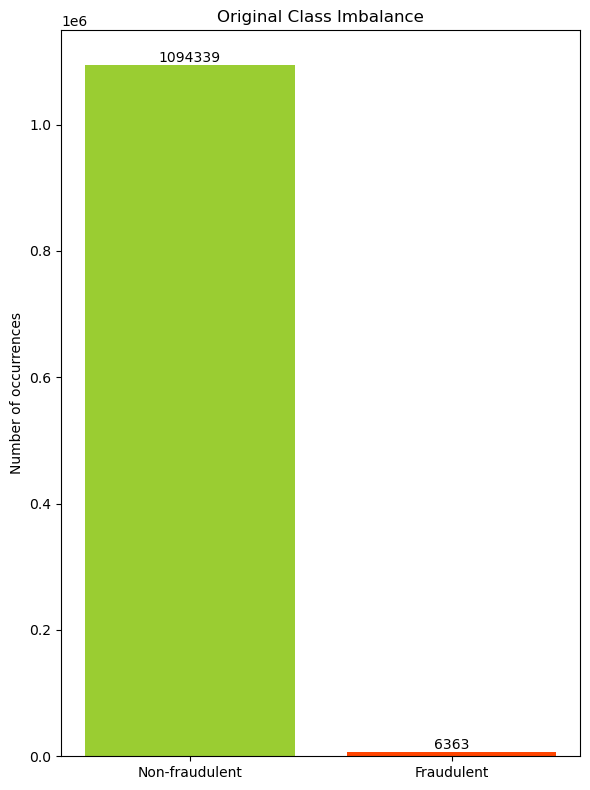

In [134]:
data = pd.read_csv('credit_card_transactions.csv')

data = data.dropna()

# Drop unnecessary columns
data = data.drop(['first', 'last', 'street', 'trans_num'], axis=1)

data.info()

# Count the number of instances for each class (fraud vs non-fraud)
class_counts_original = data['is_fraud'].value_counts()

# Prepare data for plotting
labels_original = class_counts_original.index
values_original = class_counts_original.values

# Define colors for the bars
colors_original = ['yellowgreen', 'orangered']  # orangered for fraud, yellowgreen for non-fraud

# Create the bar plot
plt.figure(figsize=(6, 8))
bars_original = plt.bar(labels_original, values_original, color=colors_original)

# Add annotations
for bar in bars_original:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Set titles and labels
plt.title('Original Class Imbalance')
plt.ylabel('Number of occurrences')
plt.xticks(labels_original, ['Non-fraudulent','Fraudulent'])  # Customize the x-ticks if necessary

# Show the plot
plt.tight_layout()
plt.show()

In [82]:

# Convert datetime columns
# Convert 'trans_date_trans_time' to datetime
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['trans_year'] = data['trans_date_trans_time'].dt.year
data['trans_month'] = data['trans_date_trans_time'].dt.month
data['trans_day'] = data['trans_date_trans_time'].dt.day
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.Timestamp.now() - data['dob']).dt.days // 365

# Drop unnecessary columns
data = data.drop(['dob'], axis=1)
data = data.drop(['trans_date_trans_time'], axis=1)

# Convert float columns to integers
data['amt'] = data['amt'].astype(int)
data['lat'] = data['lat'].astype(int)
data['long'] = data['long'].astype(int)
data['merch_lat'] = data['merch_lat'].astype(int)
data['merch_long'] = data['merch_long'].astype(int)
data['merch_zipcode'] = data['merch_zipcode'].astype(int)

# Convert categorical columns using Label Encoding
le = LabelEncoder()
data['merchant'] = le.fit_transform(data['merchant'])
data['category'] = le.fit_transform(data['category'])
data['gender'] = le.fit_transform(data['gender'])
data['city'] = le.fit_transform(data['city'])
data['state'] = le.fit_transform(data['state'])
data['job'] = le.fit_transform(data['job'])

# Check the data types after conversion
print(data.dtypes)

Unnamed: 0       int64
cc_num           int64
merchant         int64
category         int64
amt              int64
gender           int64
city             int64
state            int64
zip              int64
lat              int64
long             int64
city_pop         int64
job              int64
unix_time        int64
merch_lat        int64
merch_long       int64
is_fraud         int64
merch_zipcode    int64
trans_year       int32
trans_month      int32
trans_day        int32
age              int64
dtype: object


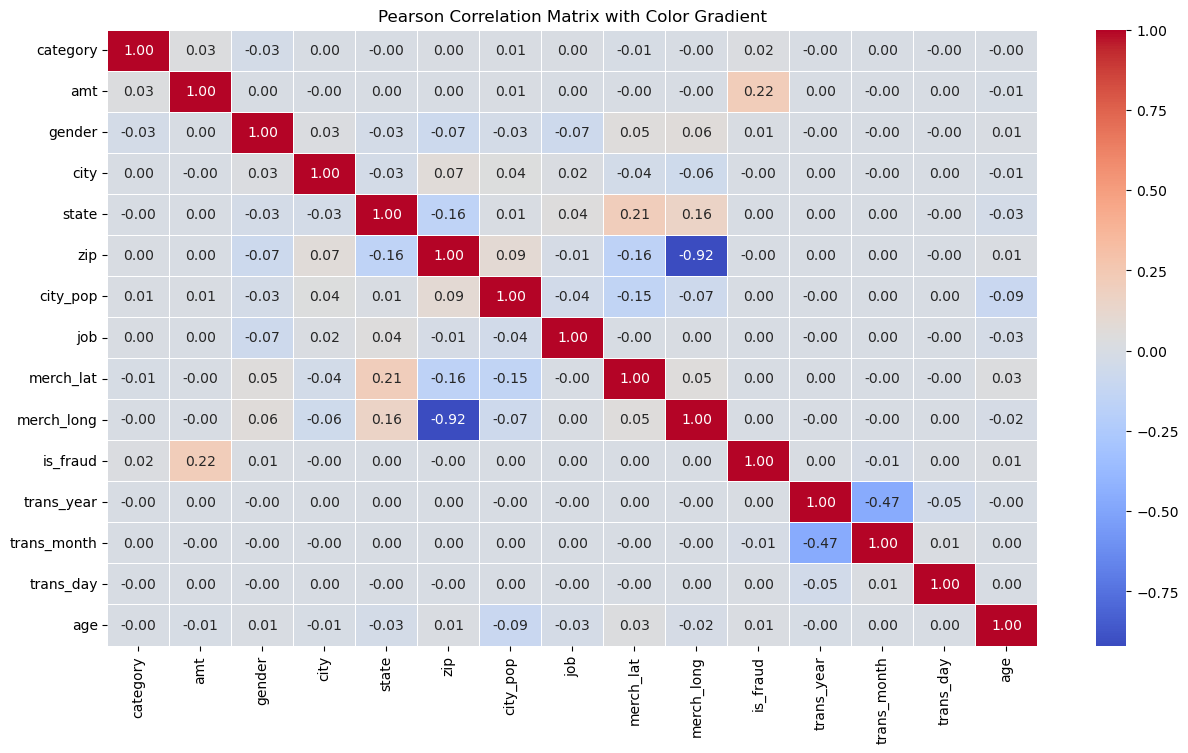

In [83]:
data.drop(columns=['Unnamed: 0','cc_num','unix_time','merch_zipcode', 'merchant', 'lat', 'long'], inplace=True)

# Compute Pearson correlation
corr_matrix = data.corr()

# Plotting the correlation matrix with a color gradient
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation Matrix with Color Gradient')
plt.show()

Original training set shape: (69993, 19), (69993,)
Resampled training set shape: (69993, 19), (69993,)
is_fraud
0    63630
1     6363
Name: count, dtype: int64


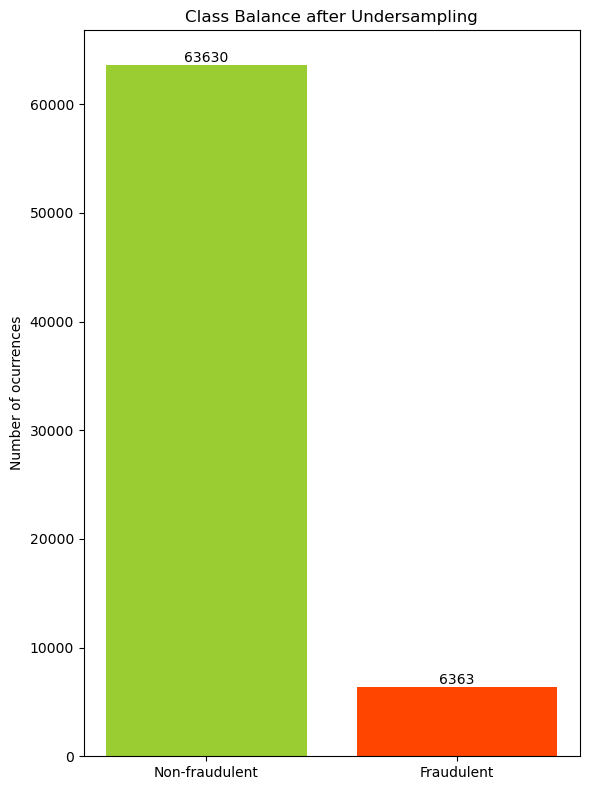

In [138]:
x = data.drop(columns=['is_fraud'])
y = data['is_fraud']

# Set a custom sampling strategy
# Example: Maintain 2:1 ratio of majority to minority samples
# For instance, if minority class has 100 samples, we want majority class to have 200 samples
majority_count = y.value_counts().max()  # Total samples in the majority class
minority_count = y.value_counts().min()  # Total samples in the minority class

# Define sampling_strategy based on the desired ratio
desired_majority_count = 10 * minority_count  # Desired majority samples (2:1 ratio)
sampling_strategy = {0: desired_majority_count, 1: minority_count}  # Map class to desired counts

# Apply RandomUnderSampler with the custom strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
x, y = rus.fit_resample(x, y)

# Check the shape of the new training set
print(f"Original training set shape: {x.shape}, {y.shape}")
print(f"Resampled training set shape: {x.shape}, {y.shape}")

# Count the number of instances for each class in the resampled training set
class_counts_resampled = y.value_counts()
print(class_counts_resampled)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

var_names = x_train.columns.to_list()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

# Assuming class_counts is a Series with the counts of fraud and non-fraud
class_counts = y.value_counts()

# Prepare data for plotting
labels = class_counts.index
values = class_counts.values

# Define colors for the bars
colors = ['yellowgreen', 'orangered']  # orangered for fraud, yellowgreen for non-fraud

# Create the bar plot
plt.figure(figsize=(6, 8))
bars = plt.bar(labels, values, color=colors)

# Add annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Set titles and labels
plt.title('Class Balance after Undersampling')
plt.ylabel('Number of ocurrences')
plt.xticks(labels, ['Non-fraudulent', 'Fraudulent'])  # Customize the x-ticks if necessary

# Show the plot
plt.tight_layout()
plt.show()


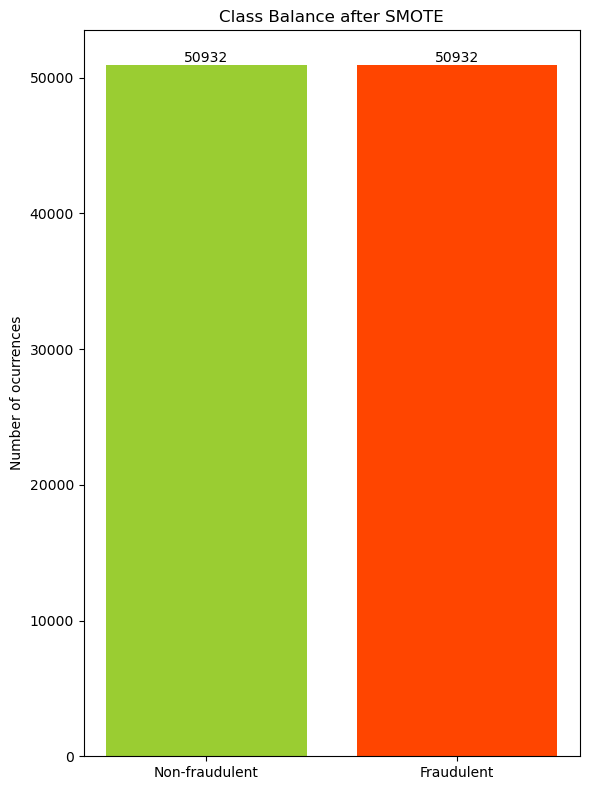

In [130]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

# Count the number of instances for each class after SMOTE
smote_class_counts = y_resampled.value_counts()

# Prepare data for plotting
smote_labels = smote_class_counts.index
smote_values = smote_class_counts.values

# Define colors for the bars
smote_colors = ['orangered', 'yellowgreen']  # orangered for fraud, yellowgreen for non-fraud

# Create the bar plot
plt.figure(figsize=(6, 8))
smote_bars = plt.bar(smote_labels, smote_values, color=smote_colors)

# Add annotations
for bar in smote_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Set titles and labels
plt.title('Class Balance after SMOTE')
plt.ylabel('Number of ocurrences')
plt.xticks(smote_labels, ['Fraudulent', 'Non-fraudulent'])  # Customize the x-ticks if necessary

# Show the plot
plt.tight_layout()
plt.show()

In [92]:
X_train = x_resampled.to_numpy()
X_test = x_test.to_numpy()
y_train = y_resampled.array
y_test = y_test.array

In [93]:
# %% Cluster the input-output space
cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=2)
clust_centers, part_matrix, _ = cl.cluster(method='fcm')

In [94]:
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

In [95]:
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
model = modbuilder.get_model()

 * Detected 2 rules / clusters
 * Detected Sugeno model type


In [96]:
modtester = SugenoFISTester(model, X_test, var_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs,axis=1)

In [97]:
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
rec_score = recall_score(y_test, y_pred)
print("Recall: {:.3f}".format(rec_score))
prec_score = precision_score(y_test, y_pred)
print("Precision Score: {:.3f}".format(prec_score))
F1_score = f1_score(y_test, y_pred)
print("F1-Score: {:.3f}".format(F1_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))

Accuracy: 0.939
Recall: 0.729
Precision Score: 0.653
F1-Score: 0.689
Kappa Score: 0.655
